In [ ]:
pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import optuna.integration.lightgbm as lgb
train=pd.read_csv('/content/drive/MyDrive/signate/コンペ　診断データを使った糖尿病発症予測/train.csv')
test=pd.read_csv('/content/drive/MyDrive/signate/コンペ　診断データを使った糖尿病発症予測/test.csv')
sample=pd.read_csv('/content/drive/MyDrive/signate/コンペ　診断データを使った糖尿病発症予測/sample_submit.csv', header=None)

In [ ]:
df = pd.concat((train, test)).reset_index(drop=True)

In [ ]:
# BMI <= 20 のデータの 'BMI' に中央値を代入する
bmi_median = df['BMI'].median()
df['BMI'] = df['BMI'].apply(lambda x: bmi_median if x <= 20 else x)
# BloodPressure == 0 のデータの 'BloodPressure' に中央値を代入する
dbp_med = int(df['BloodPressure'].median())
df['BloodPressure'] = df['BloodPressure'].apply(lambda x: dbp_med if x == 0 else x)

In [ ]:
# 統計量を確認
df.shape

(5000, 10)

In [ ]:
# 指定したcolumns以外の外れ値をクリッピングする関数
def clipping_outlier(data, exclusion_col, clip_range):
    """
    Clip outliers by clipping both sides of the distribution.

    Args:
        data: A pandas DataFrame containing the data.
        exclusion_col: A list of features to exclude from outlier clipping.
        clip_range: A float indicating the percentage to exclude on each side of the distribution.

    Returns:
        A pandas DataFrame with outliers removed.
    """
    data_copy = data.copy()
    columns = data_copy.drop(columns=exclusion_col).columns
    for column in columns:
        outliers = list(data_copy[column].quantile([clip_range, 1 - clip_range]))
        data_copy[column] = np.clip(data_copy[column], outliers[0], outliers[1])
    return data_copy


# 外れ値の処理
exclusion_col = ['index', 'Outcome']
df_5 = clipping_outlier(df, exclusion_col, 0.05)
train = df_5[:3000]
test=df_5[3000:]

In [ ]:
df_5.shape

(5000, 10)

In [ ]:
# 精度確認のための簡易学習器を定義
def simple_classifier(X, y):
    """
  feature_fraction: 各トレリングイテレーションで使用される特徴量の割合を指定します。0から1の範囲の値で設定され、1に近いほど特徴量の使用率が高くなります。

  num_leaves: LightGBMが各決定木で持つことができる葉の最大数を指定します。この値が大きいほど、モデルの複雑さが増しますが、過学習のリスクも高くなります。

  bagging_fraction および bagging_freq: ブートストラップサンプリングを行う際のデータのサブサンプルの割合と頻度を指定します。これにより、モデルのバリアンスを減らし、安定性を向上させることができます。

  regularization_factors (lambda_l1, lambda_l2): L1正則化とL2正則化の強さを制御します。これらの正則化は、モデルの過学習を防ぎ、一般化性能を向上させるために使用されます。
    """
    accuracies = []
    auc_scores = []
    params = {'objective': 'binary',
              'metric': 'binary_logloss',
              'boosting_type': 'gbdt',
              'verbose': -1,
              'random_state': 0,
              'learning_rate': 0.01,
             }
    #早期停止を行う
    #検証用データの損失関数の値が10ラウンド（イテレーション）連続で改善されない場合に、訓練を停止
    callbacks = []
    callbacks.append(lgb.early_stopping(stopping_rounds=10, verbose=False))
    #交差検証の実施
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
    for train_index, val_index in cv.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        train_data = lgb.Dataset(X_train, y_train)
        val_data = lgb.Dataset(X_val, y_val)
        valid_sets = [val_data]
        model = lgb.train(params,
                          train_data,
                          num_boost_round=1000,
                          valid_sets=valid_sets,
                          callbacks=callbacks,
                         )
        y_pred = model.predict(X_val)
        y_pred = np.rint(y_pred)
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
    return np.mean(accuracies), np.mean(auc_scores), model


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


In [ ]:
y = train['Outcome']
X = train.drop(columns=['index','Outcome','Insulin'])

In [ ]:
X['BMI_Age']=X['BMI']*X['Age']
accuracy, auc, _ = simple_classifier(X, y)
print(f'Accuracy: {accuracy}, AUC: {auc}')

[I 2024-03-10 05:54:59,027] A new study created in memory with name: no-name-32d76311-b511-4e57-8577-b6cd849051b7

feature_fraction, val_score: 0.428432:  14%|#4        | 1/7 [00:00<00:02,  2.70it/s][I 2024-03-10 05:54:59,412] Trial 0 finished with value: 0.4284319910422856 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.4284319910422856.

feature_fraction, val_score: 0.428432:  29%|##8       | 2/7 [00:00<00:02,  2.34it/s][I 2024-03-10 05:54:59,884] Trial 1 finished with value: 0.4406655567376917 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.4284319910422856.

feature_fraction, val_score: 0.428432:  43%|####2     | 3/7 [00:01<00:01,  2.28it/s][I 2024-03-10 05:55:00,331] Trial 2 finished with value: 0.4441525505637673 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.4284319910422856.

feature_fraction, val_score: 0.428432:  57%|#####7    | 4/7 [00:01<00:01,  2.25it/s][I 2024-03-10 05:55:00,785] Tr

Accuracy: 0.8156666666666667, AUC: 0.6751304600456678


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

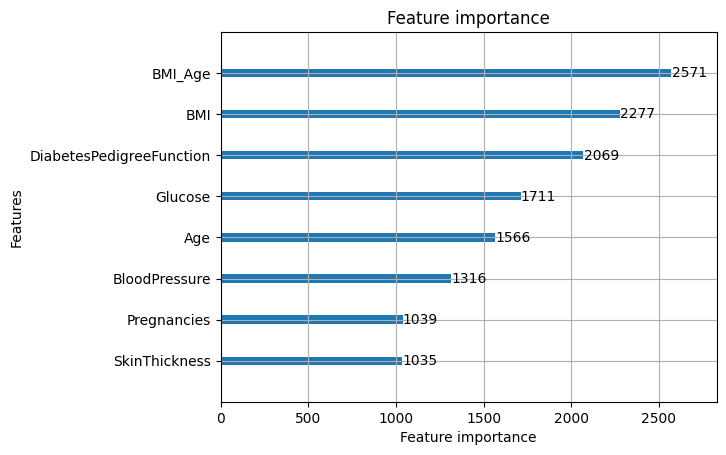

In [23]:
# 特徴量の重要度を可視化
lgb.plot_importance(_)

In [25]:

from sklearn.model_selection import train_test_split

# LightGBM用データセットに変換
train_data = lgb.Dataset(X_train, y_train)
val_data = lgb.Dataset(X_val, y_val)
# 最小限のパラメータを定義
params = {'objective': 'binary',
          'metric': 'binary_logloss',
          'verbose': -1,
          'boosting_type': 'gbdt',
         }
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10, verbose=False))
 #交差検証の実施
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
for train_index, val_index in cv.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    train_data = lgb.Dataset(X_train, y_train)
    val_data = lgb.Dataset(X_val, y_val)
    valid_sets = [val_data]
# LightGBMTunerを定義
tuner = lgb.LightGBMTuner(params=params,
                          train_set=train_data,
                          valid_sets=val_data,
                          callbacks=callbacks,
                          optuna_seed=100,
                         )

# チューニングを実行
tuner.run()
# ベストモデルを取得
best_model = tuner.get_best_booster()
# 正解率とAUCを確認
y_pred = best_model.predict(X_val)
y_pred = np.rint(y_pred)
accuracy = accuracy_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')
print(f'AUC: {auc}')


[I 2024-03-10 06:05:52,283] A new study created in memory with name: no-name-17373f28-ce4b-4d36-a401-c38630c7ed9d

feature_fraction, val_score: 0.416111:   0%|          | 0/7 [00:00<?, ?it/s][I 2024-03-10 06:05:52,362] Trial 0 finished with value: 0.41611098945346303 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.41611098945346303.

feature_fraction, val_score: 0.415773:  29%|##8       | 2/7 [00:00<00:00, 15.16it/s][I 2024-03-10 06:05:52,437] Trial 1 finished with value: 0.41577292973672114 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.41577292973672114.

feature_fraction, val_score: 0.415773:  29%|##8       | 2/7 [00:00<00:00, 15.16it/s][I 2024-03-10 06:05:52,518] Trial 2 finished with value: 0.42005533689536295 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.41577292973672114.

feature_fraction, val_score: 0.415773:  57%|#####7    | 4/7 [00:00<00:00, 13.67it/s][I 2024-03-10 06:05:52,596] Tria

Accuracy: 0.8216666666666667
AUC: 0.6763247693225811


In [27]:
test['BMI_Age']=test['BMI']*test['Age']
test = test.drop(columns=['index','Insulin'])
preds = best_model.predict(test)
y_pred = pd.Series(np.rint(preds).astype(int))

In [ ]:
test.head()

In [28]:
y_pred_series = pd.Series(y_pred)
result_df = pd.concat([sample.iloc[:, 0],y_pred_series], axis=1)
result_df.to_csv('/content/drive/MyDrive/signate/コンペ　診断データを使った糖尿病発症予測/submit.csv', header=False, index=False)